<a href="https://colab.research.google.com/github/prasad4fun/deep-learning-portfolio/blob/master/Heat_map.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [0]:
bs = 64

In [0]:
path = untar_data(URLs.PETS)/'images'

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, 
                      max_warp=0.4, p_affine=1., p_lighting=1.)

In [0]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [0]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_re(r'([^/]+)_\d+.jpg$')
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

In [0]:
data = get_data(224, bs)

In [0]:
def _plot(i,j,ax):
    x,y = data.train_ds[3]
    x.show(ax, y=y)

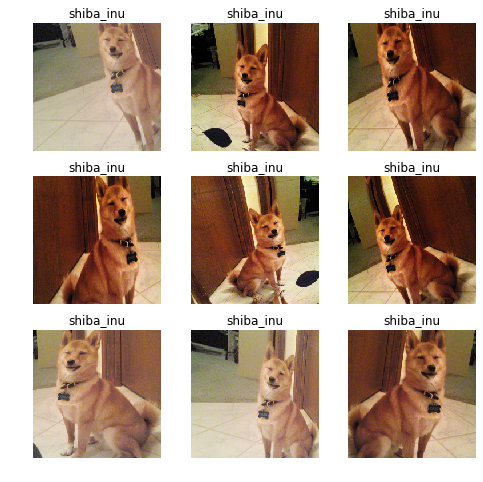

In [0]:
plot_multi(_plot, 3, 3, figsize=(8,8))

In [0]:
gc.collect()
learn = cnn_learner(data, models.resnet34, metrics=error_rate, bn_final=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 91270131.79it/s]


In [0]:
learn.fit_one_cycle(3, slice(1e-2), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,2.414210,1.158311,0.264547,01:51
1,1.439540,0.360367,0.094046,01:50
2,0.883155,0.283474,0.077808,01:50


In [0]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-3), pct_start=0.8)

epoch,train_loss,valid_loss,error_rate,time
0,0.704080,0.295176,0.071042,01:53
1,0.653750,0.284284,0.067659,01:52


In [0]:
data = get_data(352,bs)
learn.data = data

In [0]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.610936,0.267267,0.061570,03:22
1,0.582463,0.263559,0.053451,03:18


In [0]:
learn.save('352')

In [0]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 176, 176]       9,408      True      
______________________________________________________________________
BatchNorm2d          [64, 176, 176]       128        True      
______________________________________________________________________
ReLU                 [64, 176, 176]       0          False     
______________________________________________________________________
MaxPool2d            [64, 88, 88]         0          False     
______________________________________________________________________
Conv2d               [64, 88, 88]         36,864     True      
______________________________________________________________________
BatchNorm2d          [64, 88, 88]         128        True      
______________________________________________________________________
ReLU                 [64, 88, 88]         0          False     
___________________________________________________

In [0]:
data.c

37

Category Bengal

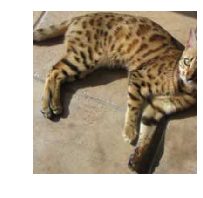

In [93]:
idx=12
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [0]:
xb,_ = data.one_item(x)
xb_im = Image(data.denorm(xb)[0])
xb = xb.cuda()

In [0]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.6, extent=(0,352,352,0),
              interpolation='bilinear', cmap='magma');

In [0]:
m = learn.model.eval()

In [0]:
from fastai.callbacks.hooks import *

def hooked_backward(cat=y):
  with hook_output(m[0]) as hook_a:
    with hook_output(m[0], grad=True) as hook_g:
      preds = m(xb)
      preds[0,int(cat)].backward()
  return hook_a,hook_g
      

In [0]:
hook_a,hook_g = hooked_backward()

In [99]:
acts  = hook_a.stored[0].cpu()
acts.shape

torch.Size([512, 11, 11])

In [100]:
avg_acts = acts.mean(0)
avg_acts.shape

torch.Size([11, 11])

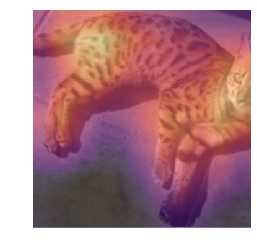

In [101]:
show_heatmap(avg_acts)